In [8]:
import os
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym
import matplotlib.pyplot as plt


In [9]:
env = gym.make("BipedalWalker-v3", hardcore=True)
env.reset()

(array([ 2.7456984e-03,  1.1409577e-05, -1.4877138e-03, -1.6000075e-02,
         9.2517346e-02,  3.4536198e-03,  8.5975885e-01, -1.3433099e-03,
         1.0000000e+00,  3.2825593e-02,  3.4535080e-03,  8.5352004e-01,
        -2.3498798e-03,  1.0000000e+00,  4.4081339e-01,  4.4581950e-01,
         4.6142212e-01,  4.8954949e-01,  5.3410202e-01,  6.0246021e-01,
         7.0914787e-01,  8.8593054e-01,  1.0000000e+00,  1.0000000e+00],
       dtype=float32),
 {})

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./sac_tensorboard/SAC_1


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 862      |
|    ep_rew_mean     | -99.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 44       |
|    total_timesteps | 3446     |
| train/             |          |
|    actor_loss      | -23.3    |
|    critic_loss     | 0.779    |
|    ent_coef        | 0.371    |
|    ent_coef_loss   | -6.23    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3345     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 667      |
|    ep_rew_mean     | -104     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 70       |
|    total_timesteps | 5339     |
| train/             |          |
|    actor_loss      | -26.8    |
|    critic_loss     | 1.3      |
|    ent_coef 

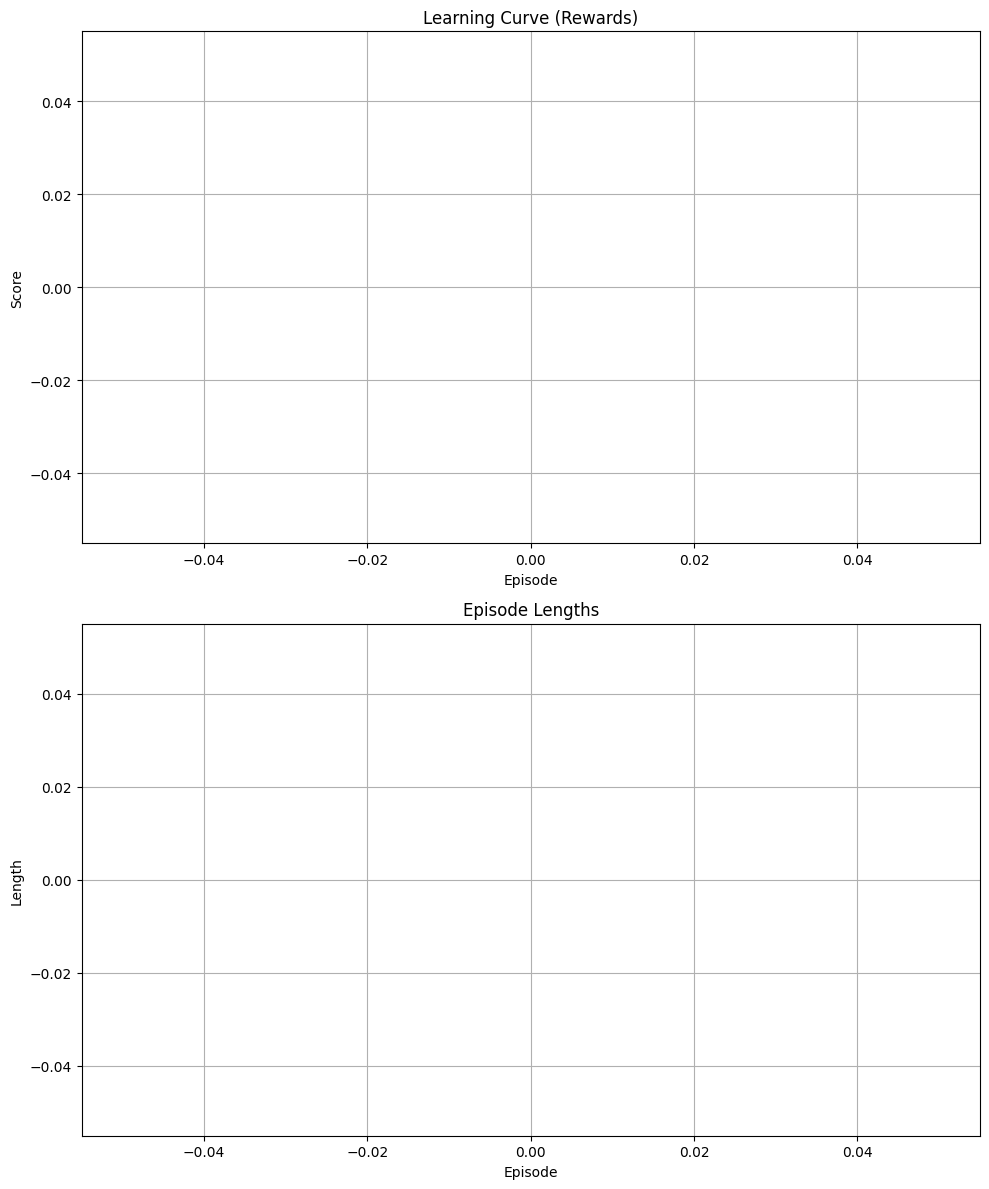

In [10]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes, EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

# Create and wrap the environment
env = gym.make("BipedalWalker-v3", hardcore=True)
env = Monitor(env)

# Define hyperparameters
policy_kwargs = dict(net_arch=[400, 300])

# Initialize the SAC model
model = SAC(
    "MlpPolicy",
    env,
    gamma=0.99,
    learning_rate=3e-4,
    buffer_size=500000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
    target_update_interval=1,
    policy_kwargs=policy_kwargs,
    tensorboard_log="./sac_tensorboard/",
    verbose=1,
)

# Training callbacks
n_episodes = 500
callback_max_episodes = StopTrainingOnMaxEpisodes(max_episodes=n_episodes, verbose=1)
eval_callback = EvalCallback(
    env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=10000,
    n_eval_episodes=10,
    verbose=1,
)

# Train the model
model.learn(total_timesteps=int(2e6), callback=[callback_max_episodes, eval_callback])

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Save the model and replay buffer
model.save("sac_bipedalwalker")
model.save_replay_buffer("replay_buffer.pkl")

# Plot learning curves
def plot_learning_curve(scores, lengths, figure_file):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    ax1.plot(scores)
    ax1.set_title("Learning Curve (Rewards)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Score")
    ax1.grid(True)

    ax2.plot(lengths)
    ax2.set_title("Episode Lengths")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Length")
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(figure_file)
    plt.show()

# Save and plot the results
figure_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(figure_dir, exist_ok=True)
figure_file = os.path.join(figure_dir, "SB3_SAC_BipedalWalker.png")

# Dummy data for plot (add episode_rewards/episode_lengths during callback)
episode_rewards = []
episode_lengths = []
plot_learning_curve(episode_rewards, episode_lengths, figure_file)


In [18]:
from stable_baselines3 import SAC

if __name__ == '__main__':
    # Create the environment in hardcore mode
    env = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")
    
    # Set up video recording
    video_save_dir = os.path.join(os.getcwd(), 'videos')
    env = gym.wrappers.RecordVideo(env, video_save_dir, episode_trigger=lambda e: e == 0)  # Save only the first episode
    
    # Load the trained model
    model = SAC.load("sac_bipedalwalker_2000ep")  

    num_test_episodes = 1
    for episode in range(num_test_episodes):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        steps = 0

        while not terminated and not truncated:
            action, _ = model.predict(observation, deterministic=True)
            observation_, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            observation = observation_
            steps += 1
            env.render()

        print(f"Test Episode {episode + 1}: Total Reward: {total_reward:.2f}, Steps: {steps}")

    env.close()
    print(f"Video saved in {video_save_dir}")

d:\Work\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Work\RL\Project\SAC_base_hardcore\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test Episode 1: Total Reward: -13.71, Steps: 1600
Video saved in d:\Work\RL\Project\SAC_base_hardcore\videos


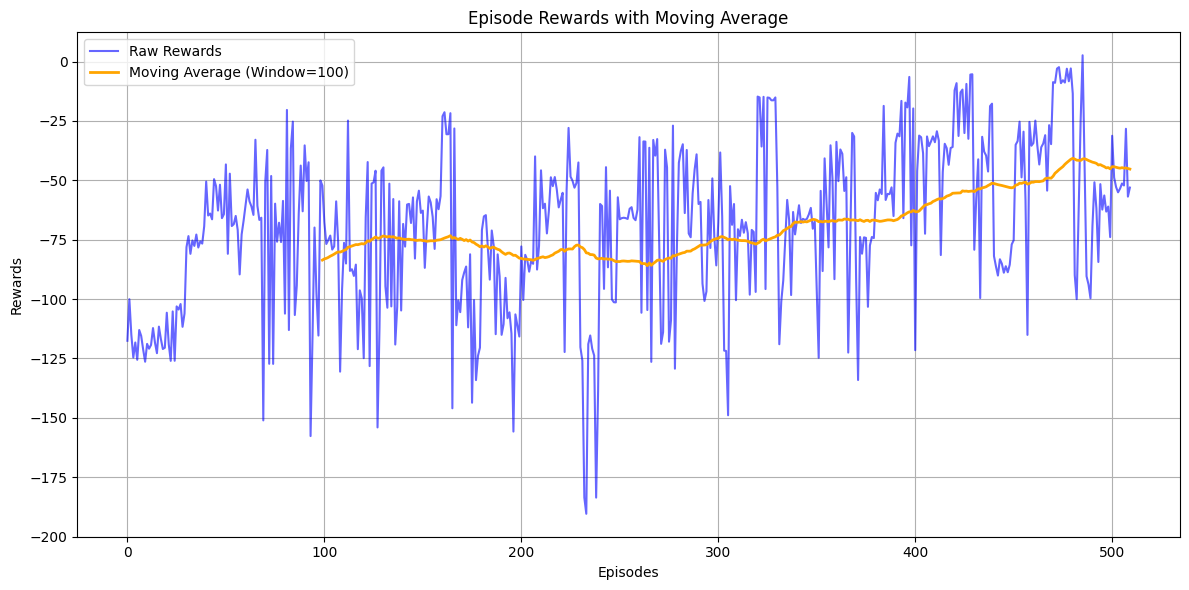

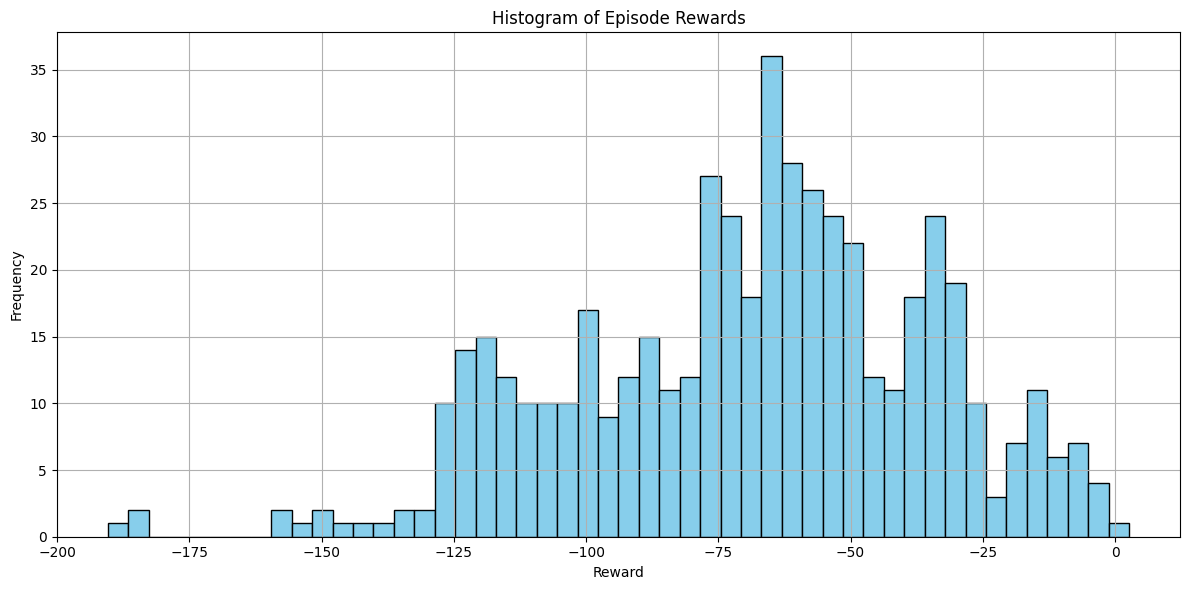

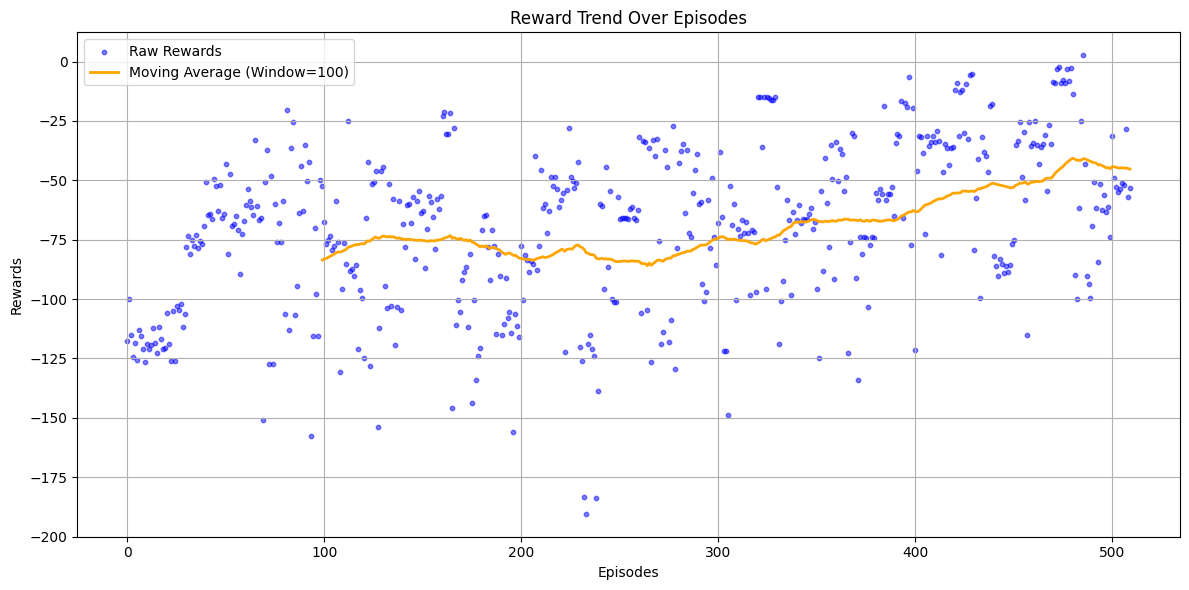

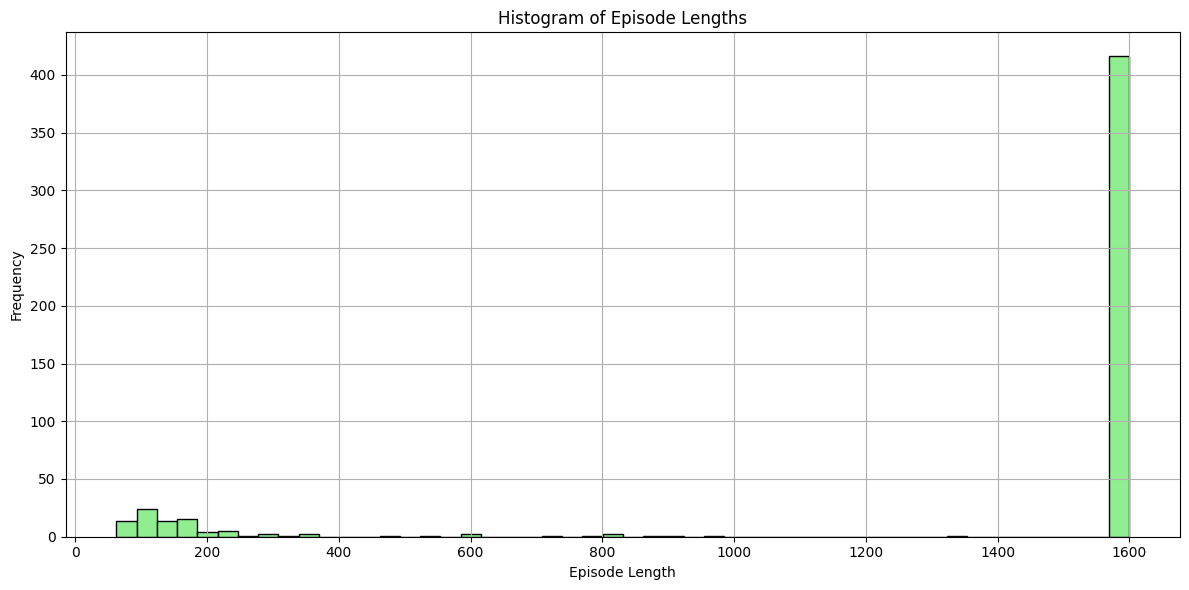

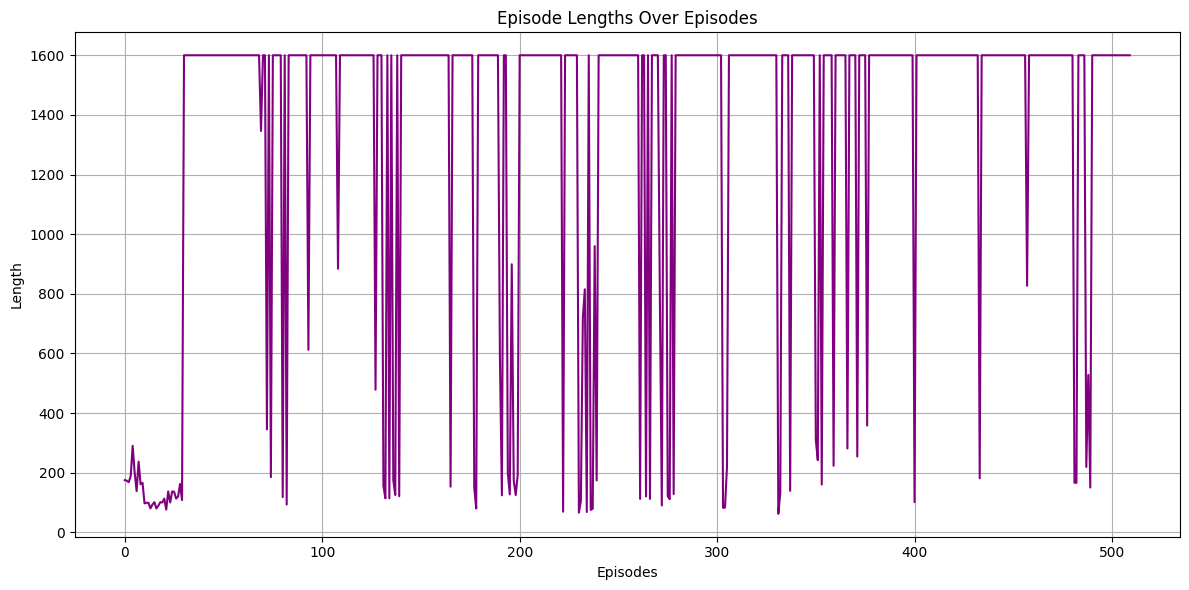

Plots and summary statistics saved to 'plots' directory.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the evaluations.npz file
data = np.load('logs/evaluations.npz')

# Extract data
results = data['results']  # Rewards: shape (n_evaluations, n_envs_per_eval)
timesteps = data['timesteps']  # Timesteps of evaluations
episode_lengths = data['ep_lengths'] if 'ep_lengths' in data.files else None

# Flatten results for all evaluations to align with episodes
rewards = results.flatten()  # All rewards in a single array
episodes = np.arange(len(rewards))  # Map rewards to episode numbers

# Create output directory for plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Moving average filter for rewards
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 100
smoothed_rewards = moving_average(rewards, window_size)

# --- Plot 1: Raw rewards and moving average ---
plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Raw Rewards', alpha=0.6, color='blue')
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Episode Rewards with Moving Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rewards_with_moving_average.png'))
plt.show()

# --- Plot 2: Histogram of rewards ---
plt.figure(figsize=(12, 6))
plt.hist(rewards, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Episode Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'reward_histogram.png'))
plt.show()

# --- Plot 3: Scatter plot of reward trend ---
plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, s=10, alpha=0.5, label='Raw Rewards', color='blue')
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Reward Trend Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'reward_trend_scatter.png'))
plt.show()

# --- Plot 4: Histogram of episode lengths (if available) ---
if episode_lengths is not None:
    episode_lengths = episode_lengths.flatten()
    plt.figure(figsize=(12, 6))
    plt.hist(episode_lengths, bins=50, color='lightgreen', edgecolor='black')
    plt.title('Histogram of Episode Lengths')
    plt.xlabel('Episode Length')
    plt.ylabel('Frequency')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'length_histogram.png'))
    plt.show()

    # --- Plot 5: Episode lengths over episodes ---
    plt.figure(figsize=(12, 6))
    plt.plot(episodes[:len(episode_lengths)], episode_lengths, label='Episode Lengths', color='purple')
    plt.title('Episode Lengths Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Length')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'episode_lengths_over_time.png'))
    plt.show()

# --- Save summary statistics ---
summary_stats = {
    "mean_reward": np.mean(rewards),
    "std_reward": np.std(rewards),
    "min_reward": np.min(rewards),
    "max_reward": np.max(rewards)
}

if episode_lengths is not None:
    summary_stats.update({
        "mean_episode_length": np.mean(episode_lengths),
        "std_episode_length": np.std(episode_lengths),
        "min_episode_length": np.min(episode_lengths),
        "max_episode_length": np.max(episode_lengths)
    })

with open(os.path.join(output_dir, 'evaluations_summary.txt'), 'w') as f:
    for key, value in summary_stats.items():
        f.write(f"{key}: {value}\n")

print("Plots and summary statistics saved to 'plots' directory.")


In [15]:
episode_lengths

array([[ 175,  173,  168,  188,  290,  200,  138,  237,  161,  166],
       [  97,   99,   99,   80,   93,  101,   80,   89,  101,  100],
       [ 113,   76,  137,  100,  137,  136,  113,  120,  162,  108],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1346],
       [1600, 1600,  345, 1600,  185, 1600, 1600, 1600, 1600, 1600],
       [ 118, 1600,   93, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600,  612, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600,  884, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600],
       [1600, 1600, 1600, 1600, 1600, 1600, 1600,  478, 1600, 1600],
       [1600,  155,  114, 1600,  114, 1600,  175,  125, 1600,  121],
       [1600, 1600, 1600, 1600, 16